In [1]:
import collections, json, re, os, sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
def strip_config(d):
    return {k: v for k, v in d.items() if k != 'config'}

game_series_states = []

line_re = '.* INFO  service.GamesService  (\{.*\})'
with open(Path.cwd() / 'data' / 'application.log') as f:
    for line in tqdm(f):
        game_series_state = re.match(line_re, line)
        if game_series_state is not None:
            state = json.loads(game_series_state.group(1))
            state = strip_config(state)
            game_series_states.append(state)
print(f'Found {len(game_series_states)} game state info logs')


Found 3021 game state info logs


In [3]:
by_game = collections.defaultdict(list)
game_counter = collections.defaultdict(int)
turn_counter = collections.defaultdict(int)

# Stupid workarounds because I wrote incomplete logs…
for state in game_series_states:
    players = ''.join([player['id'] for player in state['players']])
    if state['version'] == 0:
        game_counter[players] += 1
    
    game_id = (players, game_counter[players])
    if state['nextAction'] == 'throw':
        state['turn'] = turn_counter[game_id] // len(state['players'])
        turn_counter[game_id] += 1
        by_game[game_id].append(state)
print(f'Found {len(by_game)} games')

next(iter(by_game.values()))[1]

Found 103 games


{'version': 2,
 'players': [{'id': 'a23cfaf5-1c9d-4390-8101-830f4e196802',
   'cards': [{'id': 'H4', 'gameRepresentation': ['♥', '4'], 'endValue': 4},
    {'id': 'H9', 'gameRepresentation': ['♥', '9'], 'endValue': 9},
    {'id': 'D2', 'gameRepresentation': ['♦', '2'], 'endValue': 2},
    {'id': 'D7', 'gameRepresentation': ['♦', '7'], 'endValue': 7},
    {'id': 'S7', 'gameRepresentation': ['♠', '7'], 'endValue': 7}],
   'drawThrowable': {'id': 'S7',
    'gameRepresentation': ['♠', '7'],
    'endValue': 7}},
  {'id': '7e6f563a-4e98-4d84-8472-60e91b95b468',
   'cards': [{'id': 'SA', 'gameRepresentation': ['♠', 'A'], 'endValue': 1},
    {'id': 'C4', 'gameRepresentation': ['♣', '4'], 'endValue': 4},
    {'id': 'HK', 'gameRepresentation': ['♥', 'K'], 'endValue': 10},
    {'id': 'D8', 'gameRepresentation': ['♦', '8'], 'endValue': 8},
    {'id': 'S3', 'gameRepresentation': ['♠', '3'], 'endValue': 3}]}],
 'currentPlayer': '7e6f563a-4e98-4d84-8472-60e91b95b468',
 'nextAction': 'throw',
 'lastAct

In [4]:
class Index:
    def __init__(self):
        self.ind2item = {}
        self.item2ind = {}
    
    def store(self, item):
        ind = len(self.ind2item)
        self.ind2item[ind] = item
        self.item2ind[item] = ind
    
    def __contains__(self, item):
        return item in self.item2ind
       
    def __getitem__(self, key):
        if not key in self.item2ind:
            self.store(key)
        return self.item2ind[key]
    
test_index = Index()
assert(not 'a' in test_index)
assert(test_index['a'] == 0)
assert('a' in test_index)

In [5]:
games_index = Index()
players_index = Index()

by_player = []
for game, states in by_game.items():
    for state in states:
        for player in state['players']:
            cards = player['cards']
            game_id = games_index[game]
            player_id = players_index[player['id']]
            by_player.append({
                'game': game_id, 
                'player': player_id,
                'turn': state['turn'],
                'num_cards': len(cards),
                'points_hand': sum([card['endValue'] for card in cards])
            })
print(f'Found {len(by_player)} game/player/version data points')
by_player = pd.DataFrame(by_player)
by_player.head()

Found 3640 game/player/version data points


,game,player,turn,num_cards,points_hand
0,0,0,0,5,32
1,0,1,0,5,26
2,0,0,0,5,29
3,0,1,0,5,26
4,0,0,1,5,29


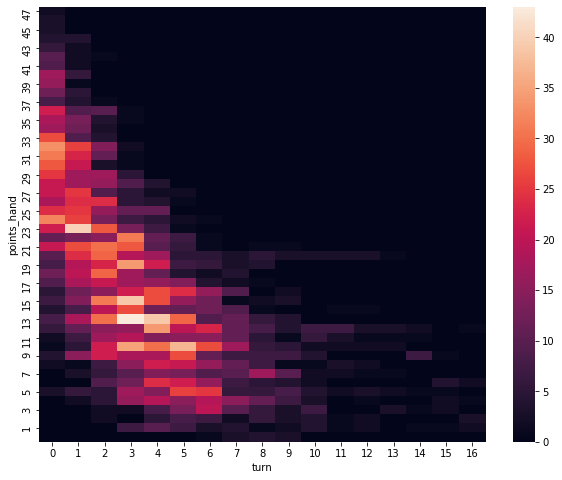

In [6]:
fig = plt.Figure(figsize=(10, 8))
ax = fig.gca()
heatmap_data = by_player.pivot_table(index='points_hand', columns='turn', values='num_cards', aggfunc=len).fillna(0).iloc[::-1]
sns.heatmap(heatmap_data, ax=ax)
fig

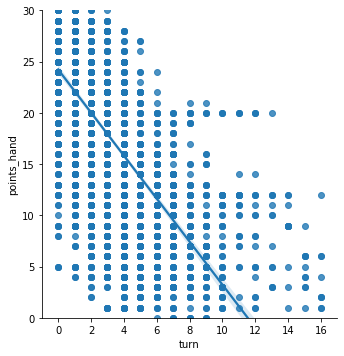

In [7]:
ax = sns.lmplot(x='turn', y='points_hand', data=by_player)
_ = ax.set(ylim=(0, 30))

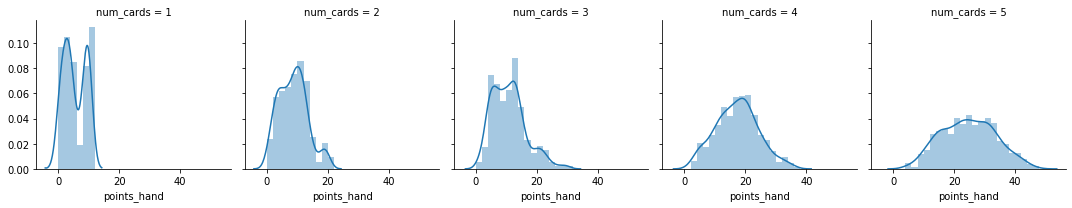

In [8]:
g = sns.FacetGrid(by_player, col='num_cards')
g.map(sns.distplot, 'points_hand', bins=np.arange(0, 50, 2))

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
games = pd.Series(by_player['game'].unique())
train_games = set(games.sample(round(len(games) * 0.5), random_state=1234))
test_games = set(games) - train_games
print(f'Sampled {len(train_games)} games for training, {len(test_games)} games for testing')

Sampled 52 games for training, 51 games for testing


In [11]:
features = by_player.copy()
features_train = features[features['game'].isin(train_games)].reset_index(drop=True)
features_test = features[features['game'].isin(test_games)].reset_index(drop=True)
print(f'Train size: {len(features_train)}, test size: {len(features_test)}')

feature_names = ['turn', 'num_cards']
target_name = 'points_hand'

X_train = features_train[feature_names]
X_test  = features_test[feature_names]
y_train = features_train[target_name].values.reshape(-1, 1) # for scaler
y_test  = features_test[target_name].values

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('predictor', LinearRegression())])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train).reshape(-1)

pipeline.fit(X_train, y_train_scaled)

pred_scaled = pipeline.predict(X_test)
pred = y_scaler.inverse_transform(pred_scaled)

print(f'RMSE linear regression: {mean_squared_error(y_test, pred, squared=False):.4f}')
print(f'Always predicting mean: {mean_squared_error(y_test, np.zeros(len(y_test)) + np.mean(y_test), squared=False):.4f}')

Train size: 1783, test size: 1857
RMSE linear regression: 6.3860
Always predicting mean: 9.5063


In [12]:
pd.DataFrame([
    {'feature': feat, 'mean': mean, 'var': var, 'weight': weight}
    for feat, mean, var, weight 
    in zip(feature_names, pipeline['scaler'].mean_, pipeline['scaler'].var_, pipeline['predictor'].coef_)
])

,feature,mean,var,weight
0,turn,3.559731,10.065838,-0.346366
1,num_cards,3.765564,1.423447,0.454491


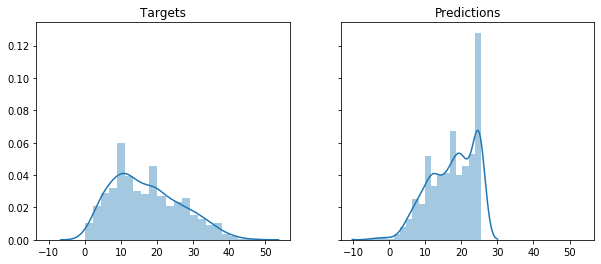

In [13]:
fig = plt.figure(figsize=(10,4))
ax1, ax2 = fig.subplots(ncols=2, sharex=True, sharey=True)
_ = sns.distplot(y_test, ax=ax1)
_ = ax1.set_title('Targets')
_ = sns.distplot(pred, ax=ax2)
_ = ax2.set_title('Predictions')

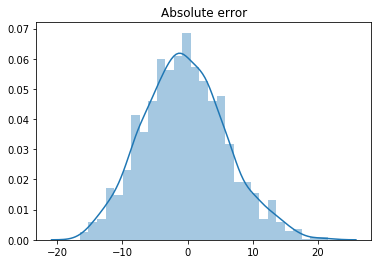

In [14]:
error = y_test - pred
ax = sns.distplot(error)
_ = ax.set_title('Absolute error')

In [15]:
n_samples = 5
sorted_by_error_size = np.argsort(error)

ind = np.hstack([sorted_by_error_size[:n_samples], sorted_by_error_size[-n_samples:]])
big_error_samples = features_test.loc[ind]
big_error_samples['prediction'] = pred[ind]
big_error_samples['error'] = error[ind]
big_error_samples

,game,player,turn,num_cards,points_hand,prediction,error
585,31,6,0,5,9,25.535891,-16.535891
588,31,6,0,5,9,25.535891,-16.535891
1170,50,6,1,5,9,24.457725,-15.457725
591,31,6,1,5,9,24.457725,-15.457725
143,5,3,2,5,8,23.379559,-15.379559
455,26,3,0,5,44,25.535891,18.464109
453,26,3,0,5,45,25.535891,19.464109
457,26,3,1,5,44,24.457725,19.542275
1801,100,15,0,5,47,25.535891,21.464109
1799,100,15,0,5,47,25.535891,21.464109
